## Constants

In [1]:
import sys, os
import pandas as pd
import numpy as np
import subprocess
import gc
import optuna
from datetime import datetime, timezone
import warnings
import xgboost as xgb
import joblib as jl
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import matthews_corrcoef
from mlflow.models import infer_signature
import mlflow
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold

today = datetime.now(timezone.utc).strftime("%Y_%m_%d")
warnings.filterwarnings("ignore")
from hyper_params import (
    mushroom_tuning_2024_08_06_1722934727_params,
)

# helpers
sys.path.append("..")
from helpers.loss_functions import *
from helpers.mlflow import *


SEED = 108
random.seed(SEED)
N_FOLDS = 5
# data
train_path = "../data/mushrooms/train.csv"
test_path = "../data/mushrooms/test.csv"
cache_path = "../data/mushrooms/cache"
# model
is_tunning = True
try:
    rs = subprocess.check_output("nvidia-smi")
    device = "cuda" if rs is not None else "cpu"
except (
    Exception
):  # this command not being found can raise quite a few different errors depending on the configuration
    print("No Nvidia GPU in system!")
    device = "cpu"
goal = "binary:logistic"

# custom metric
objective_dict = {
    "binary:logistic": {
        "metric": {
            "is_custom": False,
            "name": "logloss",
            "fval": None,
        },
        "direction": "minimize",
    }
}
# objective_dict = {
#     "binary:logistic": {
#         "metric": {
#             "is_custom": True,
#             "name": "MCC",
#             "fval": mcc_metric_v2,
#         },
#         "direction": "maximize",
#     }
# }
metric = objective_dict[goal]["metric"]["name"]
is_custom_metric = objective_dict[goal]["metric"]["is_custom"]
fval = objective_dict[goal]["metric"]["fval"]
direction = objective_dict[goal]["direction"]

best_params = {
    "device": device,
    "verbosity": 0,
    "objective": goal,
}
best_params.update(mushroom_tuning_2024_08_06_1722934727_params)
best_params

{'device': 'cuda',
 'verbosity': 0,
 'objective': 'binary:logistic',
 'tree_method': 'hist',
 'eta': 0.0696294726051571,
 'max_depth': 0,
 'min_child_weight': 1,
 'gamma': 0.044230646284796976,
 'subsample': 0.9405269471473167,
 'colsample_bytree': 0.2999355523666192,
 'lambda': 0.9746051811186938,
 'alpha': 4.210861941737071}

## Prepare data

In [2]:
train = pd.read_csv(train_path)
print(f"train size: {train.shape}")
test = pd.read_csv(test_path)
print(f"test size: {test.shape}")

train size: (3116945, 22)
test size: (2077964, 21)


In [3]:
target = "class"

categorical_cols = (
    train.drop(columns=target).select_dtypes(include="object").columns.to_list()
)
for c in categorical_cols:
    train[c] = train[c].astype("category")
    test[c] = test[c].astype("category")
numerical_cols = (
    train.drop(columns="id").select_dtypes(include="number").columns.to_list()
)

In [4]:
# X_train, X_val, y_train, y_val = train_test_split(
#     train.drop(columns=target),
#     train[target],
#     test_size=0.2,
#     random_state=42,
#     stratify=train[target],
# )
X_test = test
X_train = train.drop(columns=target)
y_train = train[target]
gc.collect()

125

Text(0.5, 1.02, 'Orginal Label for product column')

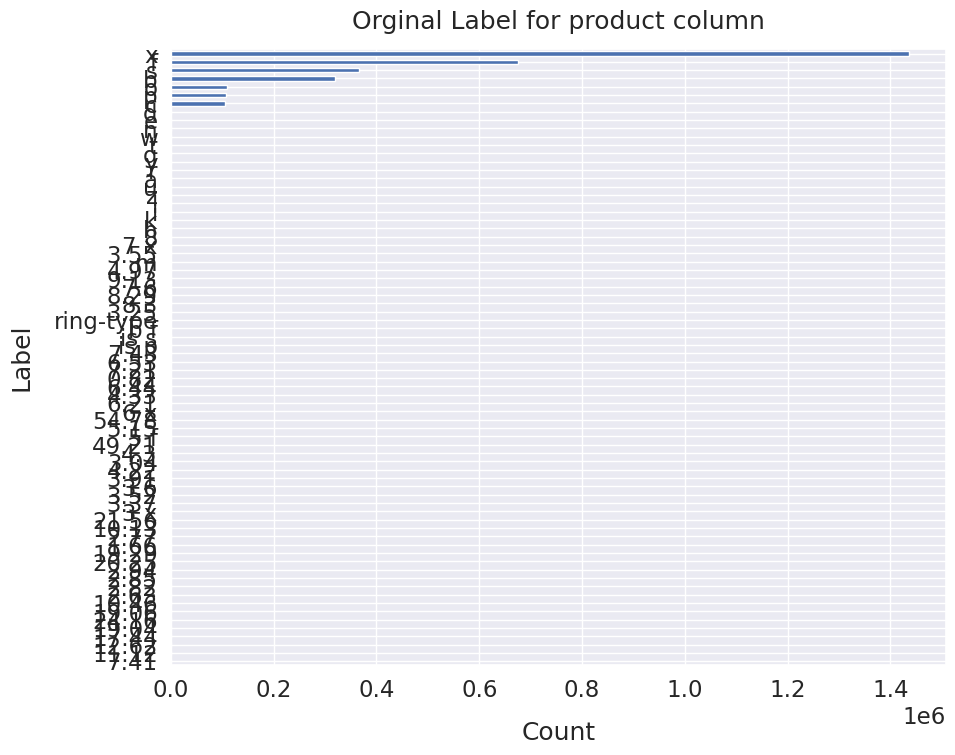

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(font_scale=1.5)
X_train['cap-shape'].value_counts().sort_values().plot(kind='barh',figsize=(10, 8))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Label", labelpad=14)
plt.title("Orginal Label for product column", y=1.02)

## Data preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler

weird_columns = [
    "cap-shape",
    "cap-surface",
    "cap-color",
    "gill-attachment",
    "gill-spacing",
    "gill-color",
    "veil-type",
    "veil-color",
    "has-ring",
    "ring-type",
    "spore-print-color",
    "habitat",
    "does-bruise-or-bleed",
    "stem-root",
    "stem-surface",
    "stem-color",
]

for col in weird_columns:
    allowed_vals = test[col].unique()
    train.loc[~train[col].isin(allowed_vals), col] = np.nan
    test.loc[~test[col].isin(allowed_vals), col] = np.nan


# Create the numerical and categorical pipelines
numerical_pipeline = Pipeline(
    steps=[
        ("num_imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("minmax", MinMaxScaler()),
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ("cat_imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine the pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_cols),
        ("cat", categorical_pipeline, categorical_cols),
    ]
)

# Create the full pipeline with the XGBoost model
data_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

# Preprocess the data
X_train_transformed = data_pipeline.fit_transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)
# X_val_transformed = preprocessor.transform(X_val)
# Binarize the target labels
lb = LabelBinarizer()

y_train_binarized = lb.fit_transform(y_train)
# y_val_binarized = lb.transform(y_val)

# prepare data for training
dtrain = xgb.DMatrix(X_train_transformed, label=y_train_binarized)
# dval = xgb.DMatrix(X_val_transformed, label=y_val_binarized)
dtest = xgb.DMatrix(X_test_transformed)

gc.collect()

77

## CV

In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


clf: xgb.XGBClassifier = xgb.XGBClassifier(
    **best_params,
    n_estimators=350,
    enable_categorical=True,
)

In [8]:
from tqdm import tqdm

skf = StratifiedKFold(n_splits=N_FOLDS)

# kf = KFold(n_splits=N_FOLDS)
y_preds = []
y_trues = []
for train_index, test_index in tqdm(skf.split(X_train_transformed, y_train_binarized)):
    X_train, X_test = X_train_transformed[train_index], X_train_transformed[test_index]
    y_train, y_test = y_train_binarized[train_index], y_train_binarized[test_index]

    # prepare data for training
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_test, label=y_test)
    #         xgb.train(
#             params=hyper_parameters,
#             dtrain=dtrain,
#             num_boost_round=10000,
#             evals=[(dval, "eval")],
#             evals_result=evals_result,
#             early_stopping_rounds=200,
#         )
    clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)])

    y_pred = clf.predict(X_test)
    y_preds.append(y_pred)
    y_trues.append(y_test)
# Concatenate the predictions and true labels
y_preds_concat = np.concatenate(y_preds)
y_trues_concat = np.concatenate(y_trues)
mcc = matthews_corrcoef(y_trues_concat, y_preds_concat)
print(f"Validation mcc score: {mcc}")

0it [00:00, ?it/s]

[0]	validation_0-logloss:0.65995
[1]	validation_0-logloss:0.61868
[2]	validation_0-logloss:0.56707
[3]	validation_0-logloss:0.52701
[4]	validation_0-logloss:0.49729
[5]	validation_0-logloss:0.46800
[6]	validation_0-logloss:0.43863
[7]	validation_0-logloss:0.40858
[8]	validation_0-logloss:0.37964
[9]	validation_0-logloss:0.35540
[10]	validation_0-logloss:0.33104
[11]	validation_0-logloss:0.31192
[12]	validation_0-logloss:0.29815
[13]	validation_0-logloss:0.28235
[14]	validation_0-logloss:0.26978
[15]	validation_0-logloss:0.25314
[16]	validation_0-logloss:0.24080
[17]	validation_0-logloss:0.22828
[18]	validation_0-logloss:0.21753
[19]	validation_0-logloss:0.20731
[20]	validation_0-logloss:0.19910
[21]	validation_0-logloss:0.18916
[22]	validation_0-logloss:0.17932
[23]	validation_0-logloss:0.16974
[24]	validation_0-logloss:0.16265
[25]	validation_0-logloss:0.15418
[26]	validation_0-logloss:0.15040
[27]	validation_0-logloss:0.14478
[28]	validation_0-logloss:0.13743
[29]	validation_0-loglos

1it [00:23, 23.08s/it]

[0]	validation_0-logloss:0.66000
[1]	validation_0-logloss:0.61870
[2]	validation_0-logloss:0.56711
[3]	validation_0-logloss:0.52710
[4]	validation_0-logloss:0.49730
[5]	validation_0-logloss:0.46802
[6]	validation_0-logloss:0.43872
[7]	validation_0-logloss:0.40865
[8]	validation_0-logloss:0.37967
[9]	validation_0-logloss:0.35543
[10]	validation_0-logloss:0.33110
[11]	validation_0-logloss:0.31198
[12]	validation_0-logloss:0.29777
[13]	validation_0-logloss:0.28199
[14]	validation_0-logloss:0.26947
[15]	validation_0-logloss:0.25286
[16]	validation_0-logloss:0.24055
[17]	validation_0-logloss:0.22805
[18]	validation_0-logloss:0.21731
[19]	validation_0-logloss:0.20711
[20]	validation_0-logloss:0.19888
[21]	validation_0-logloss:0.18898
[22]	validation_0-logloss:0.17915
[23]	validation_0-logloss:0.16959
[24]	validation_0-logloss:0.16250
[25]	validation_0-logloss:0.15402
[26]	validation_0-logloss:0.15024
[27]	validation_0-logloss:0.14462
[28]	validation_0-logloss:0.13727
[29]	validation_0-loglos

2it [00:45, 22.85s/it]

[0]	validation_0-logloss:0.66001
[1]	validation_0-logloss:0.61887
[2]	validation_0-logloss:0.56725
[3]	validation_0-logloss:0.52724
[4]	validation_0-logloss:0.49750
[5]	validation_0-logloss:0.46822
[6]	validation_0-logloss:0.43885
[7]	validation_0-logloss:0.40879
[8]	validation_0-logloss:0.37979
[9]	validation_0-logloss:0.35554
[10]	validation_0-logloss:0.33118
[11]	validation_0-logloss:0.31204
[12]	validation_0-logloss:0.29782
[13]	validation_0-logloss:0.28204
[14]	validation_0-logloss:0.26949
[15]	validation_0-logloss:0.25287
[16]	validation_0-logloss:0.24056
[17]	validation_0-logloss:0.22806
[18]	validation_0-logloss:0.21732
[19]	validation_0-logloss:0.20794
[20]	validation_0-logloss:0.19971
[21]	validation_0-logloss:0.18974
[22]	validation_0-logloss:0.17984
[23]	validation_0-logloss:0.17023
[24]	validation_0-logloss:0.16313
[25]	validation_0-logloss:0.15459
[26]	validation_0-logloss:0.15079
[27]	validation_0-logloss:0.14513
[28]	validation_0-logloss:0.13774
[29]	validation_0-loglos

3it [01:08, 22.81s/it]

[0]	validation_0-logloss:0.66003
[1]	validation_0-logloss:0.61887
[2]	validation_0-logloss:0.56726
[3]	validation_0-logloss:0.52721
[4]	validation_0-logloss:0.49744
[5]	validation_0-logloss:0.46817
[6]	validation_0-logloss:0.43885
[7]	validation_0-logloss:0.40882
[8]	validation_0-logloss:0.37980
[9]	validation_0-logloss:0.35556
[10]	validation_0-logloss:0.33122
[11]	validation_0-logloss:0.31210
[12]	validation_0-logloss:0.29789
[13]	validation_0-logloss:0.28420
[14]	validation_0-logloss:0.27155
[15]	validation_0-logloss:0.25479
[16]	validation_0-logloss:0.24237
[17]	validation_0-logloss:0.22974
[18]	validation_0-logloss:0.21888
[19]	validation_0-logloss:0.20859
[20]	validation_0-logloss:0.20031
[21]	validation_0-logloss:0.19032
[22]	validation_0-logloss:0.18041
[23]	validation_0-logloss:0.17077
[24]	validation_0-logloss:0.16363
[25]	validation_0-logloss:0.15509
[26]	validation_0-logloss:0.15129
[27]	validation_0-logloss:0.14562
[28]	validation_0-logloss:0.13822
[29]	validation_0-loglos

4it [01:31, 22.77s/it]

[0]	validation_0-logloss:0.66002
[1]	validation_0-logloss:0.61878
[2]	validation_0-logloss:0.56711
[3]	validation_0-logloss:0.52709
[4]	validation_0-logloss:0.49733
[5]	validation_0-logloss:0.46802
[6]	validation_0-logloss:0.43871
[7]	validation_0-logloss:0.40865
[8]	validation_0-logloss:0.37966
[9]	validation_0-logloss:0.35540
[10]	validation_0-logloss:0.33103
[11]	validation_0-logloss:0.31189
[12]	validation_0-logloss:0.29769
[13]	validation_0-logloss:0.28189
[14]	validation_0-logloss:0.26935
[15]	validation_0-logloss:0.25274
[16]	validation_0-logloss:0.24041
[17]	validation_0-logloss:0.22790
[18]	validation_0-logloss:0.21714
[19]	validation_0-logloss:0.20693
[20]	validation_0-logloss:0.19871
[21]	validation_0-logloss:0.18880
[22]	validation_0-logloss:0.17897
[23]	validation_0-logloss:0.16939
[24]	validation_0-logloss:0.16231
[25]	validation_0-logloss:0.15381
[26]	validation_0-logloss:0.15003
[27]	validation_0-logloss:0.14440
[28]	validation_0-logloss:0.13707
[29]	validation_0-loglos

5it [01:54, 22.88s/it]


Validation mcc score: 0.983551867293428


In [9]:
submit_df = pd.DataFrame()
submit_df["id"] = test["id"]
y_preds = clf.predict(X_test_transformed)
pred_classes = lb.inverse_transform(y_preds)
submit_df["class"] = pred_classes
submit_df.to_csv("submission.csv", index=False)